# Calculate descriptors


This tutorial includes following fundamental operations for molecular descriptors.

- Concept of descriptor function/array
- Cache mechanism
- Frequently used descriptors

In [1]:
using Pkg
Pkg.activate("..")
using MolecularGraph

 Activating environment at `~/Repository/MolecularGraph.jl_notebook/Project.toml`
┌ Info: Precompiling MolecularGraph [6c89ec66-9cd8-5372-9f91-fabc50dd27fd]
└ @ Base loading.jl:1260


loading: funcgroup.yaml
loading: ring.yaml
loading: biomolecule.yaml


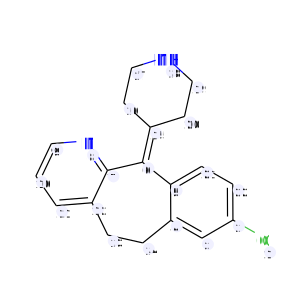

In [2]:
# Demo molecule with atom indices
mol = smilestomol("Clc4cc2c(C(/c1ncccc1CC2)=C3/CCNCC3)cc4")
canvas = SvgCanvas()
draw2d!(canvas, mol)
drawatomindex!(canvas, mol)
molsvg = tosvg(canvas, 300, 300)
display("image/svg+xml",  molsvg)

## Concept of descriptor function/array

Descriptor array is typically a vector calculated from a molecular object by a descriptor function. Most of fundamental descriptor functions are coded in `src/properties.jl`.

In [3]:
println(hydrogenconnected(mol))

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 2, 2, 0, 2, 2, 1, 2, 2, 1, 1]


`hydrogenconnected(mol)` returns a vector of the total number of hydrogens connected to each atom nodes. For example, atom \#13 is a secondary carbon so we can infer there is two hydrogens on it, therefore hydrogenconnected(mol)\[13\] is 2.

`hydrogenconnected` is defined as below in `src/properties.jl`

```julia
@cachefirst hydrogenconnected(mol::GraphMol
    ) = explicithconnected(mol) + implicithconnected(mol)
```

`@cachefirst` macro is to cache the results for fast calculation (described later). We can know that `hydrogenconnected` is derived from `explicithconnected` and `implicithconnected`.

`implicithconnected` is defined as below in `src/properties.jl`

```julia
@cachefirst function implicithconnected(mol::GraphMol)
    hcnt = (v, av) -> v === nothing ? 0 : max(0, v - av)
    return hcnt.(valence(mol), apparentvalence(mol))
end
```

so `implicithconnected` depends on `valence` and `apparentvalence`.

We can trace back the dependencies, and then can find these descriptors are derived from graph topologies (e.g. neighbors) and attributes (e.g. Atom.symbol and Bond.order). This descriptor function/array system can also deal with more complicated descriptors such as `isrotatable` and `isaromatic` as like a simple function that takes molecule object and returns an array without any adverse effects.

Note that manipulation of the molecular graph topology and attributes will break consistency in descriptor arrays. It is important to define molecular preprocessing workflow first, and then calculate descriptors.

## Cache mechanism

`Graph.@cachefirst` macro enables caching descriptor arrays already calculated. This macro is set to most of default descriptor functions. We can simply call functions with `Graph.@cache` macro to return the result and also store the result to GraphMol.cache field.


In [4]:
using MolecularGraph.Graph

mol2 = clone(mol)
v = @cache valence(mol2)
println(v)

Union{Nothing, Int64}[1, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4]


In [5]:
mol2.cache

Dict{Symbol,Any} with 1 entry:
  :valence => Union{Nothing, Int64}[1, 4, 4, 4, 4, 4, 4, 3, 4, 4  …  4, 4, 4, 4…

In [6]:
using BenchmarkTools

@benchmark valence(mol)

BenchmarkTools.Trial: 
  memory estimate:  2.44 KiB
  allocs estimate:  28
  --------------
  minimum time:     7.659 μs (0.00% GC)
  median time:      7.840 μs (0.00% GC)
  mean time:        8.027 μs (1.64% GC)
  maximum time:     692.570 μs (98.39% GC)
  --------------
  samples:          10000
  evals/sample:     4

In [7]:
@benchmark valence(mol2)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     33.194 ns (0.00% GC)
  median time:      33.877 ns (0.00% GC)
  mean time:        38.269 ns (0.00% GC)
  maximum time:     1.226 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     993

### Tips

- Some descriptor function allows keyword arguments (e.g. `coordgen(mol; forcecoordgen=true)`). If keyword arguments are given explicitly, cache will not be used.
- If the molecule object is modified (e.g. by preprocessing methods), you can recalculate and cache the result by calling the function with `@cache` macro again.
- `clearcache!(mol)` empties the cache dict.
- `precalculate!(mol)` is a convenient method to store caches of cost-effective 5 or 6 descriptors. It is recommended to apply this method after you defined your molecular model and run preprocessing methods.

In [8]:
clearcache!(mol2)
mol2.cache

Dict{Symbol,Any} with 0 entries

In [9]:
precalculate!(mol2)
mol2.cache

Dict{Symbol,Any} with 6 entries:
  :lonepair        => Union{Nothing, Int64}[3, 0, 0, 0, 0, 0, 0, 1, 0, 0  …  0,…
  :coordgen        => ([202.23 -96.8; 158.81 -72.0; … ; 115.16 2.79; 158.57 -22…
  :valence         => Union{Nothing, Int64}[1, 4, 4, 4, 4, 4, 4, 3, 4, 4  …  4,…
  :mincycles       => [[15, 16, 17, 18, 19, 20], [12, 7, 8, 9, 10, 11], [3, 4, …
  :edgemincycles   => [[22, 17, 18, 19, 20, 21], [11, 12, 7, 8, 9, 10], [2, 3, …
  :apparentvalence => [1, 4, 3, 4, 4, 4, 4, 3, 3, 3  …  2, 2, 4, 2, 2, 2, 2, 2,…

## Convention of descriptor functions

For reproducibility, there is some important conventions for descriptor functions.

- All descriptor functions take a GraphMol or SubgraphView as the only argument (optional keyword arguments are acceptable but caching will not work).
- All descriptor functions never change the molecule object given as an argument.
- All descriptor functions only refer the molecular graph and attributes, other descriptor arrays and global constants. Other external mutable objects are never refered from inside the function.
- Return value of all descriptor functions must be in Julia built-in type (for serialization to JSON)

## Frequently used descriptors


`sssr(mol)`: smallest set of smallest rings (List of rings by node set).

In [10]:
sssr(mol)

4-element Array{Array{Int64,1},1}:
 [15, 16, 17, 18, 19, 20]
 [12, 7, 8, 9, 10, 11]
 [3, 4, 5, 21, 22, 2]
 [12, 13, 14, 4, 5, 6, 7]

`isringatom(mol)`: whether the atom is a member of ring

In [11]:
print(isringatom(mol))

Bool[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

`isringbond(mol)`: whether the bond is a member of ring

In [12]:
print(isringbond(mol))

Bool[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]

`fusedrings(mol)`: list of fused ring systems by node set

In [13]:
fusedrings(mol)

2-element Array{Set{Int64},1}:
 Set([2, 11, 21, 7, 9, 10, 8, 6, 4, 3, 5, 20, 13, 12, 1])
 Set([14, 19, 17, 16, 15, 18])

`Graph.connectedcomponents(mol)`: list of connected components (molecules) by node set.

In [14]:
Graph.connectedcomponents(mol)

1-element Array{Set{Int64},1}:
 Set([2, 11, 7, 9, 8, 3, 20, 14, 12, 18  …  10, 19, 17, 22, 6, 4, 5, 13, 15, 1])

`ishacceptor(mol)`: whether the atom is a hydrogen acceptor or not (N, O or F with free lone pairs)

In [15]:
print(ishacceptor(mol))

Bool[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

`ishdonor(mol)`: whether the atom is a hydrogen donor or not (N or O with hydrogens)

In [16]:
print(ishdonor(mol))

Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

`isrotatable(mol)`: whether the bond is rotatable or not

In [17]:
print(isrotatable(mol))

Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

`hybridization(mol)`: hybridization of molecular orbitals

In [18]:
print(hybridization(mol))

[:sp3, :sp2, :sp2, :sp2, :sp2, :sp2, :sp2, :sp2, :sp2, :sp2, :sp2, :sp2, :sp3, :sp3, :sp2, :sp3, :sp3, :sp3, :sp3, :sp3, :sp2, :sp2]

`isaromatic(mol)`: whether the atom is in aromatic ring

In [19]:
print(isaromatic(mol))

Bool[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]

`isaromaticbond(mol)`: whether the bond is in aromatic ring

In [20]:
print(isaromaticbond(mol))

Bool[0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]